In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc
gc.collect()

0

In [2]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 7
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_prenatal_signals(shape, o_index):
    matrix = np.zeros(shape)
    mt = matrix.transpose()
    mt[o_index] += 15
    matrix = mt.transpose()
    return matrix

In [5]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [6]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

In [7]:
def plot_lateral_distribution(name):
    if (name == 'L3_L3'):
        shape = (n_L3, n_L3)
        radius = 1; inner = False
    elif (name == 'L3_L2'):
        shape = (n_L3, n_L2)
        radius = 0; inner = True
        
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    list_dic = {}; sum_dic = {}; total_sum = 0
    
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}
    for s_index in range(orientations):
        for t_index in range(orientations):
            list_dic[c[s_index]+c[t_index]] = []
            sum_dic[c[s_index]+c[t_index]] = 0

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), radius, inner, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        list_dic[c[s_index]+c[t_index]].append(weights[source][target])
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        total_sum += abs(weights[source][target])
                        
    category_names = ['H', 'V', 'Diagonal (45)', 'Diagonal (135)']
    results = { 'h': [], 'v': [], 'd1': [], 'd2': [] }
    %run horizontal_barchart_distribution.py
                        
    plt.figure(figsize=(17,4))
    for s_index in range(orientations):
        for t_index in range(orientations):
            plt.plot(list_dic[c[s_index]+c[t_index]], label=c[s_index]+c[t_index])
            
            print(c[s_index]+c[t_index], sum_dic[c[s_index]+c[t_index]], 
                  'of', total_sum, ':', sum_dic[c[s_index]+c[t_index]]*100/total_sum)
            
            results[c[s_index]].append(sum_dic[c[s_index]+c[t_index]])
    
    plt.legend(); plt.show()
    survey(results, category_names)

In [8]:
def normalize_weights():
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape((n_L3, n_L3))
    w_ar = np.array([])
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                for o_index in range(orientations):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    w_ar = np.append(w_ar, weights[source][target])
    
    q90 = np.percentile(w_ar, 90)
    q10 = np.percentile(w_ar, 10)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                for o_index in range(orientations):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    if (weights[source][target] > q90):
                        weights[source][target] = q90
                    elif (weights[source][target] < q10):
                        weights[source][target] = q10
    
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

# INITIALIZE

In [9]:
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 5                     # 2/3/4/5/6
margin = (field_size//2)

c_length = 20
r_length = c_length + margin*2
orientations = 4
h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 20
o_epochs = 6
# normalize_interval = 20

single_example_time = 0.45 * second
resting_time = 0.25 * second

delay = {}
delay = (0*ms, 5*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.2 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.1 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [10]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [11]:
neuron_groups = {}
neuron_groups_list = [
    ('L4', 'e'), ('L3', 'e'), ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v = v_rest_i - 40.*mV 

input_groups = {}
input_groups['input']   = PoissonGroup(n_L4, 0*Hz)

gc.collect()

1622

In [12]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

# From input to neruon groups (L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', (n_L4, n_L4))
connections['input_L4']= Synapses(input_groups['input'], neuron_groups['L4'], model=model, on_pre=pre_e, on_post=post)
connections['input_L4'].connect(True)
connections['input_L4'].w = weightMatrix[connections['input_L4'].i, connections['input_L4'].j]
# connections['input_L4'].delay = 'maxDelay'
    
neuron_neuron_conn = [
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1474

In [13]:
spike_monitors = {}
spike_monitors['input'] = SpikeMonitor(input_groups['input'])
for name,_ in neuron_groups_list:
    spike_monitors[name] = SpikeMonitor(neuron_groups[name])
    
M = {}
# M['L3_L3'] = StateMonitor(connections['L3_L3'], ['w', 'post', 'pre'], record=True)
# M['L3_L2'] = StateMonitor(connections['L3_L2'], ['w', 'post', 'pre'], record=True)
# M['L3'] = StateMonitor(neuron_groups['L3'], ['v', 'g_e', 'g_i'], record=True)
# M['L2'] = StateMonitor(neuron_groups['L2'], ['v', 'g_e', 'g_i'], record=True)

In [14]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors, M]:
    for key in obj_list:
        net.add(obj_list[key])

hh 904.0044408642295 of 14464.050251804762 : 6.250008988674744
hv 904.1105143057551 of 14464.050251804762 : 6.25074234786307
hd1 903.932092833629 of 14464.050251804762 : 6.249508796616911
hd2 904.0657679933428 of 14464.050251804762 : 6.2504329856053795
vh 903.944094525342 of 14464.050251804762 : 6.249591772626425
vv 904.1700128496319 of 14464.050251804762 : 6.251153702517132
vd1 903.7728606729888 of 14464.050251804762 : 6.248407914375297
vd2 903.7870072104669 of 14464.050251804762 : 6.248505719189521
d1h 903.9705235536063 of 14464.050251804762 : 6.249774494808691
d1v 904.2073809482364 of 14464.050251804762 : 6.251412054071184
d1d1 903.7698424320495 of 14464.050251804762 : 6.248387047184664
d1d2 903.9420360725085 of 14464.050251804762 : 6.249577541115903
d2h 904.2151895059822 of 14464.050251804762 : 6.251466040040604
d2v 904.1789403939425 of 14464.050251804762 : 6.251215424815902
d2d1 903.9081960180549 of 14464.050251804762 : 6.249343581375273
d2d2 904.07135162498 of 14464.050251804762 

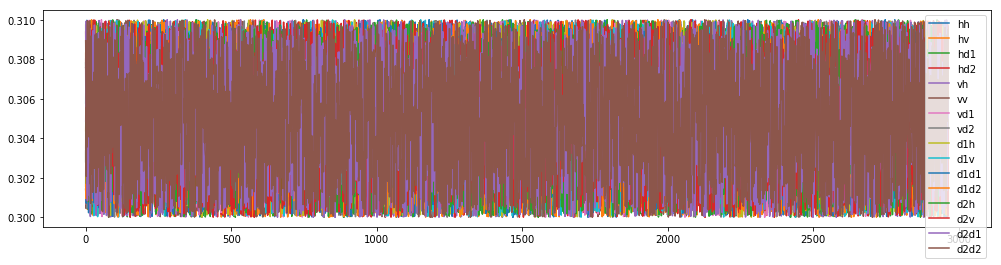

4851

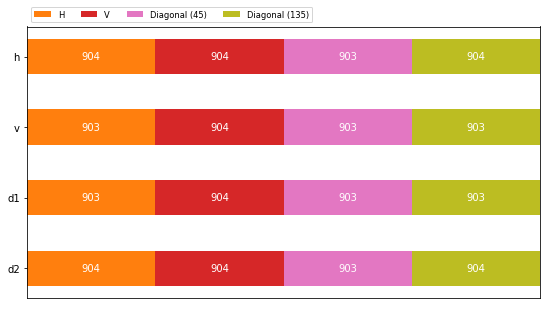

In [15]:
plot_lateral_distribution('L3_L3')
gc.collect()

In [16]:
# plot_lateral_distribution('L3_L2')
# gc.collect()

# TRAIN

In [17]:
previous_spike_count = np.zeros(n_L4)
input_groups['input'].rates = 0 * Hz

for iteration in range(o_epochs*orientations):
    o_index = iteration%orientations
    net.run(resting_time)
    
    for name, e_i in neuron_groups_list:
        if (e_i == 'e'):
            neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
            
    # load stimuli
    prenatal_stimuli = get_prenatal_signals((c_length,c_length,orientations), o_index)

    j = 0
    while j < (num_epochs):
#         if ((j+1) % normalize_interval == 0):
#             normalize_weights(o_index)
        
        spike_rates = prenatal_stimuli.reshape((n_L4)) / 8. *  input_intensity
        input_groups['input'].rates = spike_rates * Hz

        print('run example number:', j+1, 'of', num_epochs, 'in iteration', iteration, 'of', o_epochs*orientations)
        
        net.run(single_example_time, report='text')   # 0.35 s

        current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
        previous_spike_count = np.copy(spike_monitors['L4'].count[:])
        
        input_groups['input'].rates = 0 * Hz
        net.run(resting_time) 

        if np.sum(current_spike_count) < 1:
            if (input_intensity == 5):
                break;
            print("F - spike count", np.sum(current_spike_count))
            input_intensity += 1
        else:     
            print("S - spike count", np.sum(current_spike_count))
            input_intensity = start_input_intensity
            j += 1
        
        # garbage collect after each iteration
        gc.collect()
    
    if (iteration != 0 and (iteration+1)%orientations == 0):
        normalize_weights()

run example number: 1 of 20 in iteration 0 of 32
Starting simulation at t=250. ms for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 259.0
run example number: 2 of 20 in iteration 0 of 32
Starting simulation at t=0.95 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 283
run example number: 3 of 20 in iteration 0 of 32
Starting simulation at t=1.65 s for a duration of 0.45 s
0.09447857142857144 (20%) simulated in 10s, estimated 38s remaining.
0.45 (100%) simulated in 10s
S - spike count 281
run example number: 4 of 20 in iteration 0 of 32
Starting simulation at t=2.35 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 248
run example number: 5 of 20 in iteration 0 of 32
Starting simulation at t=3.05 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 283
run example number: 6 of 20 in iteration 0 of 32
Starting simulation at t=3.75 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 243
run

Starting simulation at t=34.35 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 259
run example number: 10 of 20 in iteration 2 of 32
Starting simulation at t=35.05 s for a duration of 0.45 s
0.004761126760563544 (1%) simulated in 10s, estimated 15m 35s remaining.
0.45 (100%) simulated in 12s
S - spike count 263
run example number: 11 of 20 in iteration 2 of 32
Starting simulation at t=35.75 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 252
run example number: 12 of 20 in iteration 2 of 32
Starting simulation at t=36.45 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 259
run example number: 13 of 20 in iteration 2 of 32
Starting simulation at t=37.15 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 277
run example number: 14 of 20 in iteration 2 of 32
Starting simulation at t=37.85 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 300
run example number: 15 of 20 in iteratio

S - spike count 261
run example number: 20 of 20 in iteration 4 of 32
Starting simulation at t=70.55 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 279
run example number: 1 of 20 in iteration 5 of 32
Starting simulation at t=71.5 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 268
run example number: 2 of 20 in iteration 5 of 32
Starting simulation at t=72.2 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 243
run example number: 3 of 20 in iteration 5 of 32
Starting simulation at t=72.9 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 276
run example number: 4 of 20 in iteration 5 of 32
Starting simulation at t=73.6 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 277
run example number: 5 of 20 in iteration 5 of 32
Starting simulation at t=74.3 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 283
run example number: 6 of 20 in iteration 5 of 32
Start

S - spike count 246
run example number: 13 of 20 in iteration 7 of 32
Starting simulation at t=108.4 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 253
run example number: 14 of 20 in iteration 7 of 32
Starting simulation at t=109.1 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 280
run example number: 15 of 20 in iteration 7 of 32
Starting simulation at t=109.8 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 256
run example number: 16 of 20 in iteration 7 of 32
Starting simulation at t=110.5 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 253
run example number: 17 of 20 in iteration 7 of 32
Starting simulation at t=111.2 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 271
run example number: 18 of 20 in iteration 7 of 32
Starting simulation at t=111.9 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 307
run example number: 19 of 20 in iteration 7 

Starting simulation at t=145.55 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 276
run example number: 6 of 20 in iteration 10 of 32
Starting simulation at t=146.25 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 269
run example number: 7 of 20 in iteration 10 of 32
Starting simulation at t=146.95 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 257
run example number: 8 of 20 in iteration 10 of 32
Starting simulation at t=147.65 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 295
run example number: 9 of 20 in iteration 10 of 32
Starting simulation at t=148.35 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 264
run example number: 10 of 20 in iteration 10 of 32
Starting simulation at t=149.05 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 268
run example number: 11 of 20 in iteration 10 of 32
Starting simulation at t=149.75 s for a duration of 0.45

Starting simulation at t=179.65 s for a duration of 0.45 s
0.0008145474736269564 (0%) simulated in 10s, estimated 1h 31m 55s remaining.
0.45 (100%) simulated in 13s
S - spike count 274
run example number: 14 of 20 in iteration 12 of 32
Starting simulation at t=180.35 s for a duration of 0.45 s
0.0008910398230100648 (0%) simulated in 10s, estimated 1h 24m 4s remaining.
0.45 (100%) simulated in 12s
S - spike count 256
run example number: 15 of 20 in iteration 12 of 32
Starting simulation at t=181.05 s for a duration of 0.45 s
0.0007966115702492242 (0%) simulated in 10s, estimated 1h 34m 1s remaining.
0.45 (100%) simulated in 14s
S - spike count 249
run example number: 16 of 20 in iteration 12 of 32
Starting simulation at t=181.75 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 263
run example number: 17 of 20 in iteration 12 of 32
Starting simulation at t=182.45 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 287
run example number: 18 of 20 

0.45 (100%) simulated in 9s
S - spike count 265
run example number: 4 of 20 in iteration 15 of 32
Starting simulation at t=216.1 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 284
run example number: 5 of 20 in iteration 15 of 32
Starting simulation at t=216.8 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 257
run example number: 6 of 20 in iteration 15 of 32
Starting simulation at t=217.5 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 262
run example number: 7 of 20 in iteration 15 of 32
Starting simulation at t=218.2 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 247
run example number: 8 of 20 in iteration 15 of 32
Starting simulation at t=218.9 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 272
run example number: 9 of 20 in iteration 15 of 32
Starting simulation at t=219.6 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 267
run example numb

Starting simulation at t=250.2 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 262
run example number: 13 of 20 in iteration 17 of 32
Starting simulation at t=250.9 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 280
run example number: 14 of 20 in iteration 17 of 32
Starting simulation at t=251.6 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 275
run example number: 15 of 20 in iteration 17 of 32
Starting simulation at t=252.3 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 282
run example number: 16 of 20 in iteration 17 of 32
Starting simulation at t=253. s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 270
run example number: 17 of 20 in iteration 17 of 32
Starting simulation at t=253.7 s for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 285
run example number: 18 of 20 in iteration 17 of 32
Starting simulation at t=254.4 s for a duration of 0.45 s
0

Starting simulation at t=287.35 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 261
run example number: 5 of 20 in iteration 20 of 32
Starting simulation at t=288.05 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 288
run example number: 6 of 20 in iteration 20 of 32
Starting simulation at t=288.75 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 261
run example number: 7 of 20 in iteration 20 of 32
Starting simulation at t=289.45 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 271
run example number: 8 of 20 in iteration 20 of 32
Starting simulation at t=290.15 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 244
run example number: 9 of 20 in iteration 20 of 32
Starting simulation at t=290.85 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 254
run example number: 10 of 20 in iteration 20 of 32
Starting simulation at t=291.55 s for a duration of 0.45 

0.45 (100%) simulated in 6s
S - spike count 255
run example number: 16 of 20 in iteration 22 of 32
Starting simulation at t=0.32425 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 276
run example number: 17 of 20 in iteration 22 of 32
Starting simulation at t=0.32495 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 240
run example number: 18 of 20 in iteration 22 of 32
Starting simulation at t=0.32565 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 269
run example number: 19 of 20 in iteration 22 of 32
Starting simulation at t=0.32635 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 264
run example number: 20 of 20 in iteration 22 of 32
Starting simulation at t=0.32705 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 261
run example number: 1 of 20 in iteration 23 of 32
Starting simulation at t=0.328 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count

S - spike count 268
run example number: 7 of 20 in iteration 25 of 32
Starting simulation at t=0.3607 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 268
run example number: 8 of 20 in iteration 25 of 32
Starting simulation at t=0.3614 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 287
run example number: 9 of 20 in iteration 25 of 32
Starting simulation at t=0.3621 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 264
run example number: 10 of 20 in iteration 25 of 32
Starting simulation at t=0.3628 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 268
run example number: 11 of 20 in iteration 25 of 32
Starting simulation at t=0.3635 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 275
run example number: 12 of 20 in iteration 25 of 32
Starting simulation at t=0.3642 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 264
run example number: 13 of 20 

0.45 (100%) simulated in 4s
S - spike count 263
run example number: 19 of 20 in iteration 27 of 32
Starting simulation at t=0.3976 ks for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 266
run example number: 20 of 20 in iteration 27 of 32
Starting simulation at t=0.3983 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 266
run example number: 1 of 20 in iteration 28 of 32
Starting simulation at t=0.39925 ks for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 291
run example number: 2 of 20 in iteration 28 of 32
Starting simulation at t=0.39995 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 256
run example number: 3 of 20 in iteration 28 of 32
Starting simulation at t=0.40065 ks for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 262
run example number: 4 of 20 in iteration 28 of 32
Starting simulation at t=0.40135 ks for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 28

Starting simulation at t=0.43405 ks for a duration of 0.45 s
0.00035751438435457596 (0%) simulated in 10s, estimated 3h 30m 54s remaining.
0.45 (100%) simulated in 12s
S - spike count 282
run example number: 11 of 20 in iteration 30 of 32
Starting simulation at t=0.43475 ks for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 281
run example number: 12 of 20 in iteration 30 of 32
Starting simulation at t=0.43545 ks for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 266
run example number: 13 of 20 in iteration 30 of 32
Starting simulation at t=0.43615 ks for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 265
run example number: 14 of 20 in iteration 30 of 32
Starting simulation at t=0.43685 ks for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 270
run example number: 15 of 20 in iteration 30 of 32
Starting simulation at t=0.43755 ks for a duration of 0.45 s
0.45 (100%) simulated in 9s
S - spike count 276
run example 

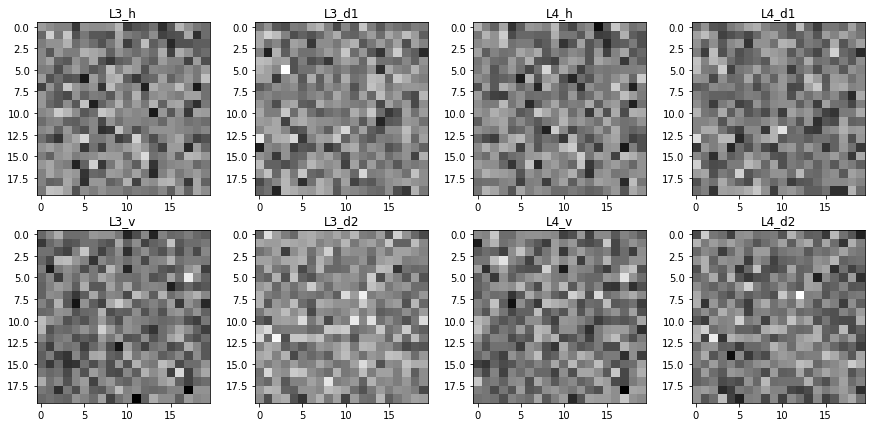

In [18]:
c_shape = (c_length, c_length, orientations)
fig, axarr = subplots(2,4, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h')
axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v')
axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1')
axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2')


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')

In [19]:
gc.collect()

30

hh 8025.764830795509 of 42831.1056305407 : 18.73816870389809
hv 904.1107203999463 of 42831.1056305407 : 2.1108741114431346
hd1 903.932092833629 of 42831.1056305407 : 2.110457060415178
hd2 904.0657624189568 of 42831.1056305407 : 2.11076914571711
vh 903.9440890381825 of 42831.1056305407 : 2.1104850685750813
vv 8234.312274482532 of 42831.1056305407 : 19.22507521872389
vd1 903.7730531764112 of 42831.1056305407 : 2.110085742292808
vd2 903.7870072104669 of 42831.1056305407 : 2.1101183214986214
d1h 903.9705235536063 of 42831.1056305407 : 2.1105467866069527
d1v 904.2073755050446 of 42831.1056305407 : 2.1110997771215603
d1d1 7884.297394825787 of 42831.1056305407 : 18.407877356319965
d1d2 903.9422855634617 of 42831.1056305407 : 2.110480857909272
d2h 904.2153835595694 of 42831.1056305407 : 2.1111184739410955
d2v 904.1789403939425 of 42831.1056305407 : 2.111033388195373
d2d1 903.9081887274875 of 42831.1056305407 : 2.1104012502608764
d2d2 7838.695708056927 of 42831.1056305407 : 18.301408737082774


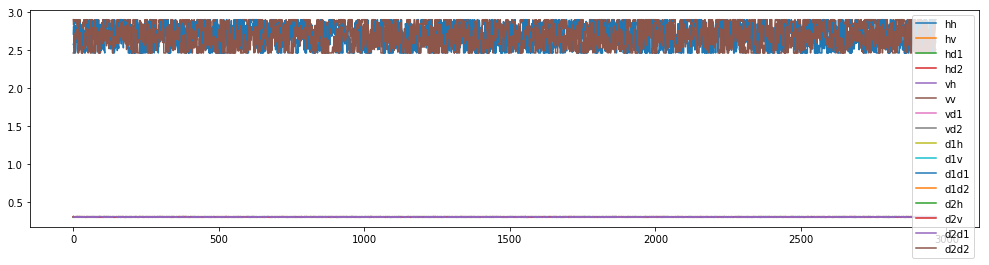

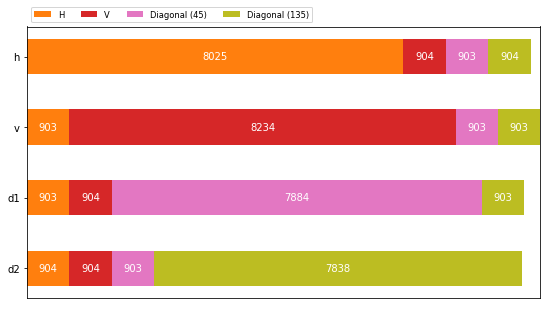

In [20]:
plot_lateral_distribution('L3_L3')

In [21]:
# plot_lateral_distribution('L3_L2')

In [22]:
# save connections
save_connections()

input_L4 L4_L3 L3_L3 L3_L2 L2_L3 L3_L4 connections saved


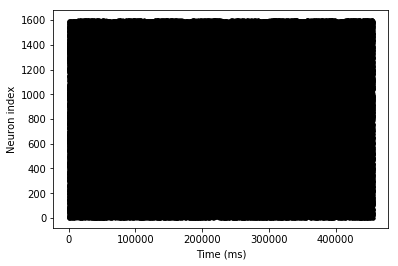

In [23]:
plot(spike_monitors['input'].t/ms, spike_monitors['input'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

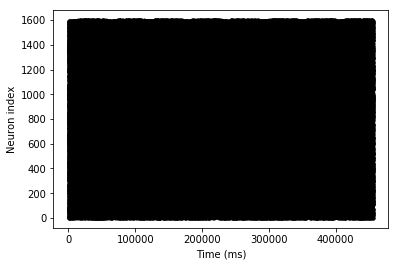

In [24]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

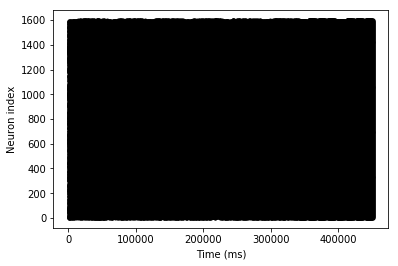

In [25]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

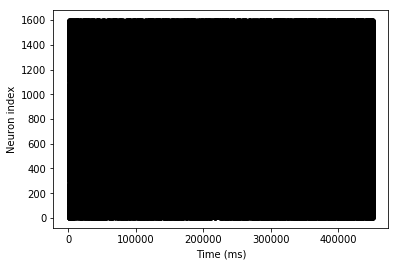

In [26]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [27]:
gc.collect()

17622

In [28]:
# figure(figsize=(15, 4))
# plot(M['L2'].t/ms, M['L2'].v[8], label='L2')
# plot(M['L3'].t/ms, M['L3'].v[8], label='L3')
# legend()

In [29]:
unique(connections['L3_L3'].w)

array([-1.22671933e-15, -1.22365636e-15, -1.22060104e-15, ...,
        6.74977276e+00,  6.90673276e+00,  6.90824202e+00])

In [30]:
unique(connections['L3_L2'].w)

array([ 0.        , 30.00000323, 30.00000523, ..., 30.00999879,
       30.00999879, 30.00999926])